# SVIPro Tutorial: Introduction to Spatial Sampling

**SVI Research Protocol & Optimization**

This notebook introduces the basics of SVIPro - A standardized framework for reproducible Street View Imagery sampling design.

---

## Table of Contents

1. [Installation and Setup](#1-installation-and-setup)
2. [Basic Concepts](#2-basic-concepts)
3. [Grid Sampling](#3-grid-sampling)
4. [Road Network Sampling](#4-road-network-sampling)
5. [Quality Metrics](#5-quality-metrics)
6. [Data Export](#6-data-export)
7. [Visualization](#7-visualization)
8. [Best Practices](#8-best-practices)

---

## 1. Installation and Setup

First, let's import the necessary libraries:

In [1]:
# Core SVIPro imports
import svipro
from svipro import (
    GridSampling, 
    RoadNetworkSampling, 
    SamplingConfig
)

# Geospatial libraries
import geopandas as gpd
from shapely.geometry import box, Polygon

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data handling
import pandas as pd
import numpy as np

# Check version
print(f"SVIPro version: {svipro.__version__}")
print(f"Authors: {svipro.__author__}")

SVIPro version: 0.1.0
Authors: Jiale Guo, Mingfeng Tang


---

## 2. Basic Concepts

### What is SVIPro?

SVIPro provides **scientific, reproducible, and documented** spatial sampling methods for urban studies using Street View Imagery.

### Key Features

- ✅ **Multiple Sampling Strategies**: Grid, road network, and more
- ✅ **Reproducibility**: Same parameters = same results (using seeds)
- ✅ **Quality Assessment**: Built-in metrics and validation
- ✅ **Standardized Output**: GeoJSON with complete metadata

### Core Components

1. **SamplingConfig**: Configuration parameters (spacing, CRS, seed)
2. **SamplingStrategy**: Algorithm for generating sample points
3. **GeoDataFrame**: Output format with spatial data

---

## 3. Grid Sampling

Grid sampling is the simplest and most transparent method. It creates a regular grid of sample points.

### 3.1 Define Your Study Area

First, create a boundary for your area of interest (AOI):

In [2]:
# Create a rectangular boundary (in degrees, roughly 10km x 10km)
# This example uses Milan, Italy coordinates
# Note: Using larger area for better sampling demonstration
milan_boundary = box(9.10, 45.40, 9.30, 45.60)

print(f"Boundary type: {type(milan_boundary)}")
print(f"Boundary area: {milan_boundary.area:.4f} square degrees")
print(f"Bounds: {milan_boundary.bounds}")

Boundary type: <class 'shapely.geometry.polygon.Polygon'>
Boundary area: 0.0400 square degrees
Bounds: (9.1, 45.4, 9.3, 45.6)


### 3.2 Configure Sampling Parameters

Create a `SamplingConfig` object with your parameters:

In [3]:
# Create configuration
# Note: When using EPSG:4326 (geographic), spacing is treated as degrees
# For Milan area, we use a small decimal value for spacing
config = SamplingConfig(
    spacing=0.005,      # ~0.5 degrees (approximately 50km at this latitude)
    crs="EPSG:4326",   # WGS84 coordinate system
    seed=42             # For reproducibility
)

print(f"Spacing: {config.spacing} degrees")
print(f"CRS: {config.crs}")
print(f"Seed: {config.seed}")

Spacing: 0.005 degrees
CRS: EPSG:4326
Seed: 42


# Create grid sampling strategy
grid_strategy = GridSampling(config)

# Generate sample points
print("Generating grid sample points...")
grid_points = grid_strategy.generate(milan_boundary)

# Display results
print(f"Generated {len(grid_points)} sample points")

if len(grid_points) > 0:
    print(f"\nColumns in output:")
    print(grid_points.columns.tolist())
    print(f"\nFirst 5 points:")
    print(grid_points.head())
else:
    print("\n⚠️ No points generated! Try:")
    print("  1. Using a larger boundary")
    print("  2. Using smaller spacing value")

In [4]:
# Create grid sampling strategy
grid_strategy = GridSampling(config)

# Generate sample points
grid_points = grid_strategy.generate(milan_boundary)

# Display results
print(f"Generated {len(grid_points)} sample points")
print(f"\nColumns in output:")
print(grid_points.columns.tolist())
print(f"\nFirst 5 points:")
print(grid_points.head())

Generated 1521 sample points

Columns in output:
['geometry', 'sample_id', 'strategy', 'timestamp', 'grid_x', 'grid_y', 'spacing_m']

First 5 points:
               geometry                sample_id       strategy  \
0  POINT (9.105 45.405)  grid_sampling_0001_0001  grid_sampling   
1   POINT (9.105 45.41)  grid_sampling_0001_0002  grid_sampling   
2  POINT (9.105 45.415)  grid_sampling_0001_0003  grid_sampling   
3   POINT (9.105 45.42)  grid_sampling_0001_0004  grid_sampling   
4  POINT (9.105 45.425)  grid_sampling_0001_0005  grid_sampling   

                    timestamp  grid_x  grid_y  spacing_m  
0  2026-01-24T17:18:19.286810       1       1      0.005  
1  2026-01-24T17:18:19.286810       1       2      0.005  
2  2026-01-24T17:18:19.286810       1       3      0.005  
3  2026-01-24T17:18:19.286810       1       4      0.005  
4  2026-01-24T17:18:19.286810       1       5      0.005  


### 3.4 Visualize Grid Sample Points

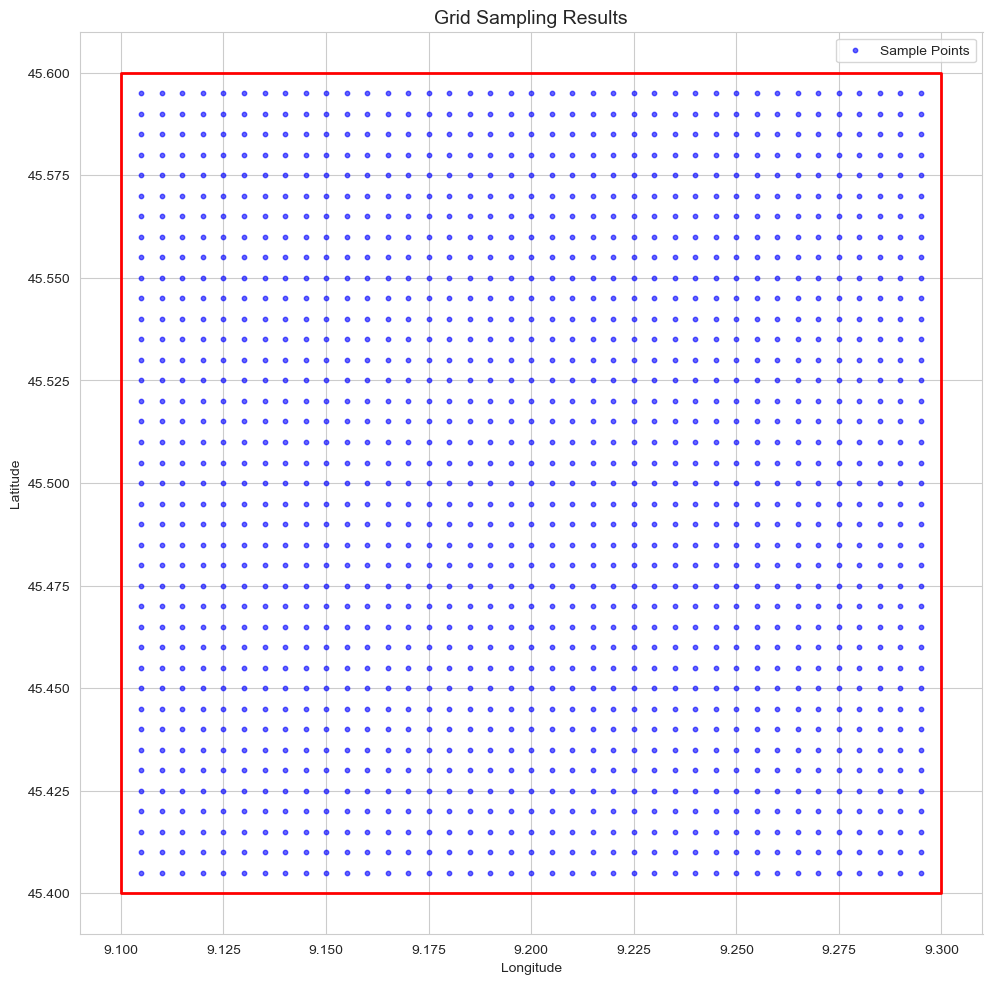

In [5]:
# Plot the grid sampling results
fig, ax = plt.subplots(figsize=(10, 10))

# Plot boundary
gpd.GeoSeries([milan_boundary]).plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Plot sample points using matplotlib scatter (more reliable)
ax.scatter(
    grid_points.geometry.x,
    grid_points.geometry.y,
    s=10,  # markersize
    c='blue',
    alpha=0.6,
    label='Sample Points'
)

ax.set_title('Grid Sampling Results', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.tight_layout()
plt.show()

---

## 4. Road Network Sampling

Road network sampling places points along actual roads, which is more realistic for street view studies.

### 4.1 Configure Road Network Sampling

**Note**: This requires an internet connection to download road data from OpenStreetMap.

In [6]:
# Create configuration for road network sampling
# Note: When using EPSG:4326 (geographic), spacing is in degrees
road_config = SamplingConfig(
    spacing=0.005,      # ~0.5 degrees
    crs="EPSG:4326",
    seed=42
)

# Create road network sampling strategy
road_strategy = RoadNetworkSampling(
    road_config,
    network_type='drive',    # Use drivable roads only
    # road_types={'primary', 'secondary'}  # Optional: filter by road type
)

print("Road network strategy created")
print(f"Network type: {road_strategy.network_type}")

Road network strategy created
Network type: drive


### 4.2 Generate Road Network Sample Points

This may take a moment as it downloads road data from OpenStreetMap:

In [7]:
# Generate road network sample points
print("Downloading road network from OpenStreetMap...")
road_points = road_strategy.generate(milan_boundary)

print(f"\nGenerated {len(road_points)} sample points along roads")
print(f"\nFirst 5 points:")
print(road_points.head())

AttributeError: module 'osmnx' has no attribute 'utils_graph'

### 4.3 Calculate Road Network Metrics

In [ ]:
# Get road network specific metrics
road_metrics = road_strategy.calculate_road_network_metrics()

print("Road Network Metrics:")
print(f"  Sample points: {road_metrics['n_points']}")
print(f"  Network edges: {road_metrics['n_edges']}")
print(f"  Network nodes: {road_metrics['n_nodes']}")
print(f"  Total road length: {road_metrics['total_road_length_km']:.2f} km")
print(f"  Average node degree: {road_metrics['avg_degree']:.2f}")

if road_metrics['road_type_distribution']:
    print(f"\nRoad type distribution:")
    for road_type, count in sorted(road_metrics['road_type_distribution'].items()):
        print(f"  {road_type}: {count} points")

### 4.4 Visualize Road Network Sample Points

In [ ]:
# Plot road network sampling results
fig, ax = plt.subplots(figsize=(10, 10))

# Plot boundary
gpd.GeoSeries([milan_boundary]).plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Plot sample points using matplotlib scatter
if 'highway' in road_points.columns and len(road_points) > 0:
    # Color by highway type if available
    import numpy as np
    unique_highways = road_points['highway'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_highways)))
    
    for i, hw in enumerate(unique_highways):
        mask = road_points['highway'] == hw
        ax.scatter(
            road_points[mask].geometry.x,
            road_points[mask].geometry.y,
            s=15,
            c=[colors[i]],
            alpha=0.7,
            label=hw
        )
    ax.legend(title='Highway Type')
else:
    ax.scatter(
        road_points.geometry.x,
        road_points.geometry.y,
        s=15,
        c='green',
        alpha=0.7,
        label='Road Points'
    )

ax.set_title('Road Network Sampling Results', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.tight_layout()
plt.show()

---

## 5. Quality Metrics

SVIPro provides built-in metrics to assess sampling quality.

In [ ]:
# Calculate coverage metrics for grid sampling
grid_metrics = grid_strategy.calculate_coverage_metrics()

print("Grid Sampling Metrics:")
print(f"  Number of points: {grid_metrics['n_points']}")
print(f"  Coverage area: {grid_metrics['area_km2']:.4f} km²")
print(f"  Sampling density: {grid_metrics['density_pts_per_km2']:.2f} pts/km²")
print(f"  Bounds: {grid_metrics['bounds']}")
print(f"  CRS: {grid_metrics['crs']}")

### 5.1 Compare Strategies

In [ ]:
# Compare metrics between strategies
comparison = pd.DataFrame({
    'Grid Sampling': [
        grid_metrics['n_points'],
        grid_metrics['density_pts_per_km2'],
        'Uniform'
    ],
    'Road Network Sampling': [
        road_metrics['n_points'],
        road_metrics['n_points'] / grid_metrics['area_km2'],
        'Road-following'
    ]
}, index=['Points', 'Density (pts/km²)', 'Pattern'])

print("Strategy Comparison:")
print(comparison)

---

## 6. Data Export

Export your sampling results with complete metadata.

In [ ]:
# Export grid sampling to GeoJSON with metadata
grid_strategy.to_geojson("grid_samples_milan.geojson", include_metadata=True)
print("✓ Grid samples exported to: grid_samples_milan.geojson")

# Export road network sampling to GeoJSON
road_strategy.to_geojson("road_samples_milan.geojson", include_metadata=True)
print("✓ Road network samples exported to: road_samples_milan.geojson")

### 6.1 Export Config as Dictionary

In [ ]:
# Export configuration as dictionary (for JSON/YAML)
config_dict = config.to_dict()

print("Configuration as dictionary:")
for key, value in config_dict.items():
    if key != 'boundary':  # Skip boundary WKT (too long)
        print(f"  {key}: {value}")

---

## 7. Visualization

SVIPro provides built-in visualization tools.

In [ ]:
# Import visualization functions
from svipro import plot_coverage_statistics, plot_spatial_distribution

# Create coverage statistics plot
fig = plot_coverage_statistics(
    grid_points,
    title='Grid Sampling Coverage Statistics'
)
plt.show()

### 7.1 Spatial Distribution Plot

In [ ]:
# Create spatial distribution plot
fig, ax = plt.subplots(figsize=(10, 8))
plot_spatial_distribution(grid_points, milan_boundary, ax=ax)
ax.set_title('Spatial Distribution of Grid Sample Points')
plt.show()

---

## 8. Best Practices

### 8.1 Choosing the Right Strategy

| Strategy | Best For | Pros | Cons |
|----------|----------|------|------|
| **Grid** | General studies, baseline comparison | Simple, reproducible, uniform coverage | May not follow accessible routes |
| **Road Network** | Street view, transportation studies | Realistic placement, follows roads | Requires OSM data, less uniform |

### 8.2 Setting Parameters

**Spacing Guidelines:**
- **Urban areas**: 50-100m (dense coverage)
- **Suburban areas**: 100-200m (moderate coverage)
- **Rural areas**: 200-500m (sparse coverage)

**Reproducibility:**
- Always set a `seed` for reproducible results
- Document your configuration parameters
- Use the same CRS for comparison studies

### 8.3 Common Issues and Solutions

**Issue 1: No points generated**

```python
# Solution: Check boundary size vs spacing
# Try: (1) Larger boundary, (2) Smaller spacing
```

**Issue 2: OSM download fails**

```python
# Solution: Check internet connection and boundary validity
# Try: (1) Different network_type ('walk' vs 'drive'),
#      (2) Smaller boundary area
```

**Issue 3: Points outside boundary**

```python
# Solution: Check CRS compatibility
# Use projected CRS (e.g., EPSG:3857) for accurate spacing
```

---

## Summary

In this tutorial, you learned:

1. ✅ How to install and import SVIPro
2. ✅ How to create sampling configurations
3. ✅ How to generate grid and road network samples
4. ✅ How to calculate quality metrics
5. ✅ How to export results with metadata
6. ✅ How to visualize sampling results

### Next Steps

- Try different spacing values
- Compare multiple strategies on the same area
- Use your own study area boundary
- Integrate with your research workflow

### Resources

- **Documentation**: `docs/` folder
- **API Reference**: `docs/api_reference.md`
- **Case Studies**: `docs/case_studies/`
- **GitHub**: https://github.com/GuojialeGeographer/GProcessing2025

---

**Authors**: Jiale Guo & Mingfeng Tang  
**Institution**: Politecnico di Milano  
**Course**: Geospatial Processing  
**Date**: 2025-01-23